In [2]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img
from datetime import date
from datetime import datetime

# my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve
import mean_rev_utl as mru

## Importing and processing data

In [180]:
#parameters
short = 20
long = 120

#inverse volatility parameters
window = 30 #days
estimator = 'stdv' #'satchell'

USequity_list =  ['MDY', 'QQQ'] #['SPY', 'DIA', 'QQQ', 'MDY', 'IWC'] # 'IJR'  # 
GLOBequity_list = ['IEFA', 'VEA', 'ADRE'] #['ACWI', 'SPDW', 'VEA', 'IEFA'] # 'ADRE'  #
bond_list = ['TLT', 'PHB', 'VCSH'] #['TLT', 'BND', 'TIP', 'PHB', 'VCSH'] # 'BWX'  #
commodities_list = ['SLV', 'DBB', 'DBO', 'GLD'] #['DBB', 'GLD', 'DBA', 'DBO', 'UNG', 'CORN'] # 'SLV', 'PPLT', 'SOYB'  #
currencies = ['CYB']  #['UUP', 'CYB', 'FXB', 'FXE', 'FXY'] # 

list_securities = USequity_list + GLOBequity_list + bond_list + commodities_list
debug_xl = False

start_date = '2006-01-03'
end_date = "2020-11-26"

In [181]:
US_equity = pd.read_csv('../data/key_market_USequties.csv', index_col = 0, header = [0,1])
global_equity = pd.read_csv('../data/key_market_GLOBequties.csv', index_col = 0, header = [0,1])
bonds = pd.read_csv('../data/key_market_bonds.csv', index_col = 0, header = [0,1])
currencies = pd.read_csv('../data/key_market_currencies.csv', index_col = 0, header = [0,1])
commodities = pd.read_csv('../data/key_market_commodities.csv', index_col = 0, header = [0,1])
df_tot = pd.concat([US_equity, global_equity, bonds, currencies, commodities], axis = 1)
df_close = df_tot.iloc[:, df_tot.columns.get_level_values(1)=='Close']
df_close.columns = df_close.columns.droplevel(1)
data = df_close[start_date:end_date]
data = data[list_securities] 

In [182]:
data

,MDY,QQQ,IEFA,VEA,ADRE,TLT,PHB,VCSH,SLV,DBB,DBO,GLD
Date,,,,,,,,,,,,
2006-01-03,111.594032,36.145535,NaN,NaN,21.032892,55.619267,NaN,NaN,NaN,NaN,NaN,53.119999
2006-01-04,112.385788,36.521805,NaN,NaN,21.208908,55.752625,NaN,NaN,NaN,NaN,NaN,53.299999
2006-01-05,112.549034,36.679302,NaN,NaN,21.196581,55.685913,NaN,NaN,NaN,NaN,NaN,52.340000
2006-01-06,113.830574,37.344292,NaN,NaN,21.633083,55.582962,NaN,NaN,NaN,NaN,NaN,53.720001
2006-01-09,114.344872,37.493015,NaN,NaN,21.846048,55.619267,NaN,NaN,NaN,NaN,NaN,54.599998
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,385.591095,289.536499,62.171463,42.445534,50.475384,155.814362,18.166086,80.598221,22.420000,16.770000,7.39,175.160004
2020-11-20,385.325592,287.555969,62.368740,42.587433,50.944073,157.196457,18.118708,80.569084,22.490000,16.959999,7.45,175.690002
2020-11-23,391.314301,287.565918,62.359337,42.615807,51.604076,156.476181,18.196661,80.569084,21.930000,16.700001,7.53,172.229996


In [183]:
#compute unique names
title = ''
unique_name = 'MATS+inv_vol_' + estimator
for i in list_securities:
        unique_name += '_' + i
        title += i + ' '
title += 'short '+ str(short) + ' long '+ str(long) + 'estimator: ' + estimator 
unique_name = unique_name + '_short_' + str(short) + '_long_'+ str(long)

### Mean average strategy

In [184]:
def create_mean_rev_signal(data, long_wind, short_wind):
    '''
    input 
    data: pandas dataframe with prices of securities (name of the column security)
    long_wind: the long window you want for the mean reverse strategy
    short_wind: the short windw you want for the mean reverse strategy
    
    output:
    final_df: pandas df filled with 1 or -1 accordingly to the mean reverse strategy
    df_rolling_mean: df with the means over the different windows for debugging
    '''
    final_df = pd.DataFrame()
    df_rolling_mean = pd.DataFrame()
    for sec in data.columns:
        sec_df = pd.DataFrame(columns = [sec])
        long_wind_df = data[sec].rolling(long_wind).mean() #creating the long window df
        df_rolling_mean[sec + '_long'] = long_wind_df #for debugging
        short_wind_df = data[sec].rolling(short_wind).mean() #creating the short window df
        df_rolling_mean[sec + '_short'] = short_wind_df #for debugging
        sec_df[sec] = (short_wind_df - long_wind_df) #subtracting the long and the short
        sec_df[sec] = sec_df[sec].apply(lambda x: 1 if x>0 else -1) #subsitute positive value with 1 and negative with a -1
        final_df[sec] = sec_df[sec]
    return final_df, df_rolling_mean

def filter_dataframe_holc(df_tot, list_securities):
    df_output = pd.DataFrame()
    for security in list_securities:
        df_output[security + '_open'] = df_tot[security]['Open']
        df_output[security + '_high'] = df_tot[security]['High']
        df_output[security + '_low'] = df_tot[security]['Low']
        df_output[security + '_close'] = df_tot[security]['Close']
        #df_output.dropna(inplace = True)
    return df_output

In [185]:
#main

signal_df = mru.create_mean_rev_signal(data, long, short)[0]
#new_index = signal_df.index.strftime('%Y-%m-%d')
#signal_df.set_index(new_index, inplace = True)

df_rolling_mean = mru.create_mean_rev_signal(data, long, short)[1]
data_r = data.div(data.shift(1))-1 #returns of securities

### Inverse probability weighting

In [186]:
if estimator == 'satchell':
    data_ohlc = filter_dataframe_holc(df_tot, list_securities)
    data_ohlc = data_ohlc[start_date: end_date]
    df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
    try:
        df_satchell_volat = ve.index_df(df_satchell_volat, data, window)
    except ValueError:
        df_satchell_volat = ve.index_df(df_satchell_volat, data, window+1)
    df_satchell_inv_volat = df_satchell_volat.applymap(lambda x: 1/x)
    df_weighted = hep.df_wheighted(df_satchell_inv_volat.fillna(0))
    
if estimator == 'stdv':    
    #df_strd_dev = ve.dataframe_strd_dev(data, window) #create standard dev dataframe
    #df_strd_dev = ve.index_df(df_strd_dev, data, window) #reindex accordingly to data
    data_perc = hep.return_df(data) #compute the returns
    inv_volat_data = hep.df_inverse_volatility(data_perc, window) #compute the inverse volatility dataframe
    df_weighted = hep.df_wheighted(inv_volat_data) #normalize the rows for the weights

In [187]:
# compute data earnings
data_earnings = hep.df_earnings((signal_df * df_weighted), data_r.fillna(0))
#data_earnings.dropna(inplace = True)
data_earnings.index = pd.to_datetime(data_earnings.index)

In [75]:
# excel debug

if debug_xl == True:
        with pd.ExcelWriter('AW_dbg.xlsx') as writer:
            new_index = data.index.tz_convert(None)
            data.set_index(new_index).to_excel(writer, sheet_name='prices')
            new_index = data_r.index.tz_convert(None)
            data_r.set_index(new_index).to_excel(writer, sheet_name='returns')
            new_index = signal_df.index.tz_convert(None)
            signal_df.set_index(new_index).to_excel(writer, sheet_name='signals')
            new_index = df_rolling_mean.index.tz_convert(None)
            df_rolling_mean.set_index(new_index).to_excel(writer, sheet_name='rolling mean')
            new_index = data_earnings.index.tz_convert(None)
            data_earnings.set_index(new_index).to_excel(writer, sheet_name='AW_port_rets')

In [100]:
data_earnings[120:]

,SPY,DIA,QQQ,MDY,IWC,ACWI,SPDW,VEA,IEFA,TLT,...,TIP,PHB,VCSH,DBB,GLD,DBA,DBO,UNG,CORN,Tot
2006-06-26,-0.000443,-0.000423,-2.098065e-04,-0.000430,-0.000672,NaN,NaN,NaN,NaN,0.000342,...,0.000390,NaN,NaN,NaN,0.000227,NaN,NaN,NaN,NaN,-0.001220
2006-06-27,0.000862,0.001111,1.491527e-03,0.000805,0.001133,NaN,NaN,NaN,NaN,-0.000893,...,-0.000567,NaN,NaN,NaN,-0.000454,NaN,NaN,NaN,NaN,0.003488
2006-06-28,-0.000674,-0.000547,-5.745831e-04,-0.000322,-0.000301,NaN,NaN,NaN,NaN,0.000954,...,0.000777,NaN,NaN,NaN,-0.000118,NaN,NaN,NaN,NaN,-0.000804
2006-06-29,-0.001965,-0.001889,-2.303737e-03,-0.002040,-0.002058,NaN,NaN,NaN,NaN,-0.000613,...,-0.002160,NaN,NaN,NaN,0.001692,NaN,NaN,NaN,NaN,-0.011337
2006-06-30,-0.000008,0.000010,3.516311e-04,-0.000135,-0.000310,NaN,NaN,NaN,NaN,-0.001870,...,-0.001846,NaN,NaN,NaN,-0.001367,NaN,NaN,NaN,NaN,-0.005174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.000079,0.000034,1.063450e-04,0.000145,0.000063,0.000103,0.000113,0.000114,0.000137,-0.000139,...,0.000122,0.000281,0.000427,0.000202,-0.000038,-0.000153,-0.000013,0.000275,-0.000123,0.001509
2020-11-20,-0.000130,-0.000131,-9.337465e-05,-0.000011,0.000088,-0.000049,0.000077,0.000063,0.000060,-0.000240,...,0.000283,-0.000154,-0.000139,0.000383,0.000062,-0.000025,-0.000080,-0.000112,0.000031,-0.000218
2020-11-23,0.000114,0.000205,4.764616e-07,0.000255,0.000326,0.000076,0.000030,0.000013,-0.000003,0.000122,...,-0.000099,0.000251,0.000000,-0.000562,-0.000425,0.000306,-0.000106,-0.000122,0.000237,0.000708
2020-11-24,0.000311,0.000271,2.036209e-04,0.000272,0.000236,0.000306,0.000277,0.000302,0.000275,0.000263,...,0.000039,0.000061,0.000326,0.000349,-0.000314,0.000160,-0.000449,-0.000197,0.000000,0.002805


## Create and export plot for the report

#### Table of returns:

In [190]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

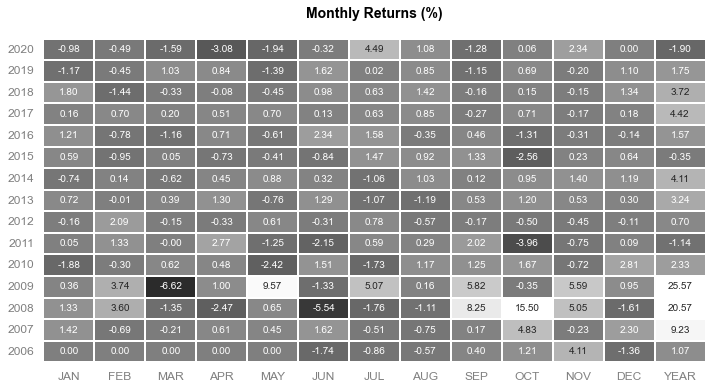

In [193]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

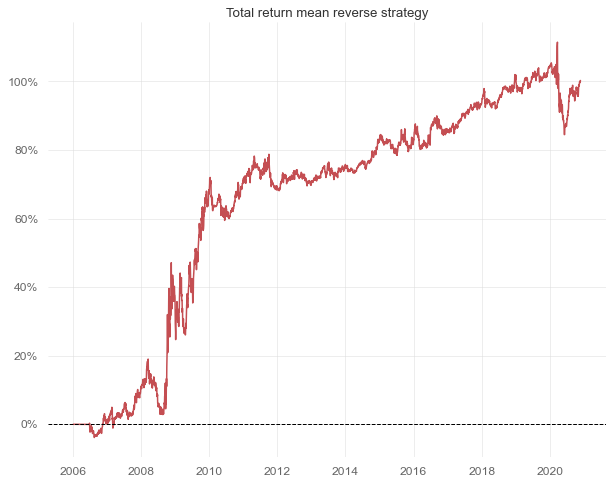

In [194]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#bench_return_try = bench_return[700:800]
#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='r', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
#ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
fig.savefig('../img/returns_'+ unique_name + '.png')

In [178]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(bench_return_try['Tot'])

bench_return['Tot'][701] = 0.9999

In [179]:
bench_return[700:800]

,SPY,DIA,QQQ,MDY,IWC,ACWI,SPDW,VEA,IEFA,TLT,...,TIP,PHB,VCSH,DBB,GLD,DBA,DBO,UNG,CORN,Tot
Date,,,,,,,,,,,,,,,,,,,,,
2008-10-14,0.014800,0.014312,0.043268,0.029464,0.024008,0.006446,-0.026012,0.020752,NaN,-0.006441,...,-0.022873,-0.031306,NaN,0.009335,-0.002561,-0.006107,-0.013072,-0.017154,NaN,0.024097
2008-10-15,0.098448,0.093947,0.089557,0.116560,0.074904,0.095346,0.131925,0.110265,NaN,0.009564,...,-0.003432,0.015678,NaN,0.053592,-0.013504,0.060319,0.050000,0.034392,NaN,0.999900
2008-10-16,-0.041658,-0.058914,-0.054248,-0.058732,-0.063639,-0.038666,-0.030286,-0.051358,NaN,-0.005158,...,0.006427,0.023951,NaN,0.038581,0.048253,-0.000807,0.029542,-0.030822,NaN,-0.287397
2008-10-17,0.005972,0.024232,-0.001240,0.015147,0.023596,0.015911,-0.003675,0.015929,NaN,-0.006877,...,0.004068,0.006136,NaN,-0.033657,0.026233,-0.029851,-0.003149,-0.019269,NaN,0.034052
2008-10-20,-0.060079,-0.065570,-0.027863,-0.051134,-0.033947,-0.057657,-0.039749,-0.049281,NaN,0.007990,...,-0.013722,0.006173,NaN,0.023795,-0.016708,-0.023110,-0.043948,0.022164,NaN,-0.422239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03-03,0.007507,0.009141,0.000751,0.007791,0.022934,0.004084,0.001455,0.007960,NaN,-0.006681,...,-0.002253,0.033827,NaN,-0.023111,-0.009788,-0.002667,-0.027628,-0.039953,NaN,-0.020034
2009-03-04,-0.023691,-0.023210,-0.026671,-0.028530,-0.028344,-0.040181,-0.041515,-0.041624,NaN,-0.004582,...,-0.001950,-0.011670,NaN,-0.085143,-0.011662,-0.038564,-0.060783,-0.006215,NaN,-0.474466
2009-03-05,0.040848,0.039261,0.030003,0.046444,0.061155,0.040205,0.037762,0.040443,NaN,0.027811,...,0.009257,0.039654,NaN,0.020016,0.033712,0.017499,0.017080,0.061202,NaN,0.566945


In [64]:
#fig, ax = plt.subplots(figsize=(10,8))
#ax.set_title('SPY mean reverse strategy returns')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#fig.set_facecolor('white')
#ax.set_facecolor('white')
#ax.plot(compsum(data_earnings['SPY']), lw=1.5, color='r', alpha=1)
#ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
#ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
##ax.legend()
#fig = ax.get_figure()
#fig.set_size_inches(10,8)
#fig.savefig('../img/SPY_ret_MATS_long_80_short_20.png')

In [65]:
#fig, ax = plt.subplots(figsize=(10,8))
#ax.set_title('GLD mean reverse strategy returns')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)
#fig.set_facecolor('white')
#ax.set_facecolor('white')
#ax.plot(compsum(data_earnings['GLD']), lw=1.5, color='r', alpha=1)
#ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
#ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
##ax.legend()
#fig = ax.get_figure()
#fig.set_size_inches(10,8)
#fig.savefig('../img/GLD_ret_MATS_long_80_short_20.png')

#### Distribution plot:

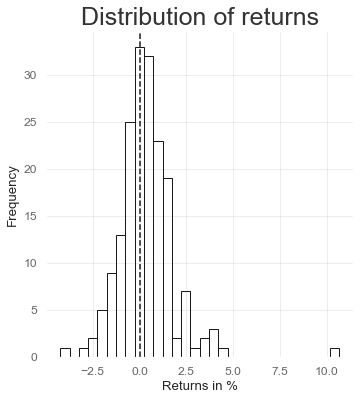

In [78]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('../img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [79]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('../data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


,index,value
0,Annualised return,0.044973
1,Annualised volatility,0.070053
2,Sharpe ratio,0.642168
3,Sortino ratio,0.935528
4,Adjusted sortino,0.661518
5,Skew,0.171884
6,Kurtosis,21.720639
7,Max drawdown,-0.106846
8,GPR,0.151124
9,Calmar ratio,0.406332


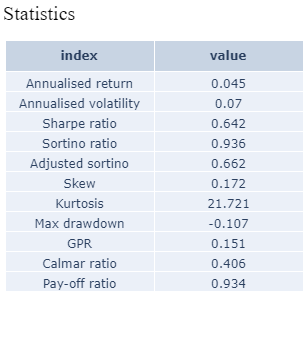

In [80]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='../img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')

In [81]:
# Param
grayscale=True 
figsize= (10, 5.5)
fontname='Arial' 
lw=1
log_scale=False
match_volatility=False
compound=False
ylabel="Drawdown"
resample=None 
subtitle=True 
savefig =  '../img/temp/under_water_plot' + unique_name + '.png'
show=True

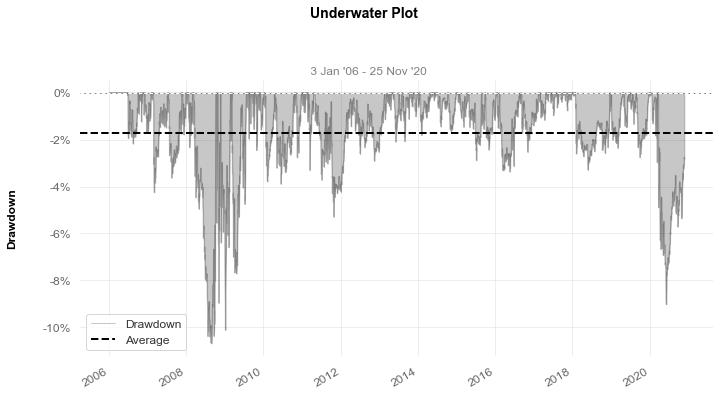

In [82]:
from quantstats._plotting.core import plot_timeseries

dd = to_drawdown_series(data_earnings['Tot'])
#bench_dd = to_drawdown_series(benchmark_portf_perc['TOT'])

fig = plot_timeseries(dd, title='Underwater Plot',
                            hline=dd.mean(), hlw=2, hllabel="Average",
                            returns_label="Drawdown",
                            compound=compound, match_volatility=match_volatility,
                            log_scale=log_scale, resample=resample,
                            fill=True, lw=lw, figsize=figsize,
                            ylabel=ylabel,
                            fontname=fontname, grayscale=grayscale,
                            subtitle=subtitle,
                            savefig=savefig, show=show)
fig

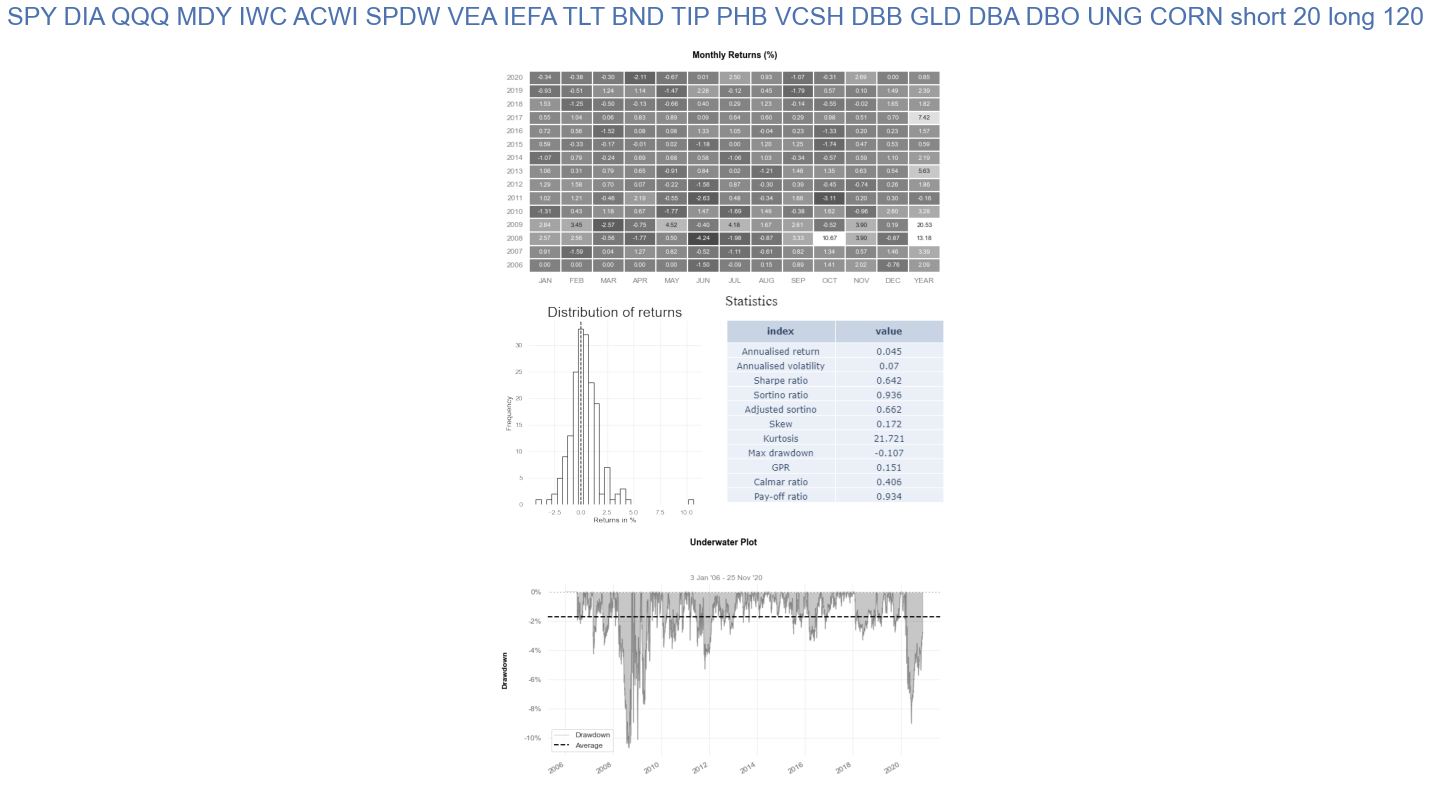

In [83]:
fig = plt.figure(figsize=(8, 13.55))
gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('../img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('../img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('../img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('../img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)

fig.suptitle(title, fontsize=25, y = 0.92, color = 'b') #add the correct leverage

plt.savefig('../reports/report_' + unique_name + '.png', dpi = 1200)

In [104]:
#creating benchmark
len(data_earnings.columns)

21

In [205]:
#creating benchmark
from math import isnan

def number_nan(row):
    count = 0
    for i in range(len(row)):
        if isnan(row[i]):
            count += 1
    return len(row)-count

signal_df_bench = signal_df.copy()
signal_df_bench['n_sec_active'] = signal_df_bench.apply(number_nan, axis = 1)
signal_df_bench = signal_df_bench.apply(lambda row: row/row['n_sec_active'], axis = 1)
signal_df_bench.drop(columns =['n_sec_active'], inplace = True)
signal_df_bench

,MDY,QQQ,IEFA,VEA,ADRE,TLT,PHB,VCSH,SLV,DBB,DBO,GLD
Date,,,,,,,,,,,,
2006-06-23,-0.200000,-0.200000,NaN,NaN,-0.200000,-0.200000,NaN,NaN,NaN,NaN,NaN,0.200000
2006-06-26,-0.200000,-0.200000,NaN,NaN,-0.200000,-0.200000,NaN,NaN,NaN,NaN,NaN,0.200000
2006-06-27,-0.200000,-0.200000,NaN,NaN,-0.200000,-0.200000,NaN,NaN,NaN,NaN,NaN,0.200000
2006-06-28,-0.200000,-0.200000,NaN,NaN,-0.200000,-0.200000,NaN,NaN,NaN,NaN,NaN,0.200000
2006-06-29,-0.200000,-0.200000,NaN,NaN,-0.200000,-0.200000,NaN,NaN,NaN,NaN,NaN,-0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333
2020-11-20,0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333
2020-11-23,0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333,0.083333,0.083333,0.083333,-0.083333,0.083333


In [206]:
bench_return = hep.df_earnings(signal_df_bench, data_r.fillna(0))
bench_return.index = pd.to_datetime(bench_return.index)

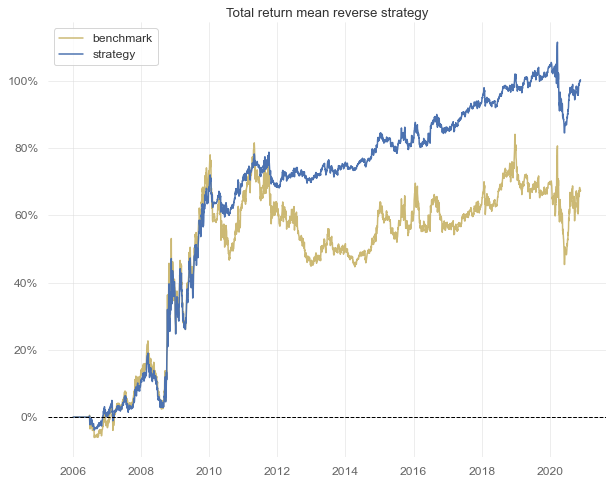

In [217]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#bench_return_try = bench_return[700:800]
#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Total return mean reverse strategy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(bench_return['Tot']), lw=1.5, color='y', alpha=1, label = 'benchmark')
ax.plot(compsum(data_earnings['Tot']), lw=1.5, color='b', alpha=1, label = 'strategy')
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
fig = ax.get_figure()
fig.set_size_inches(10,8)
#fig.savefig('../img/returns_benchmark_'+ unique_name + '.png')

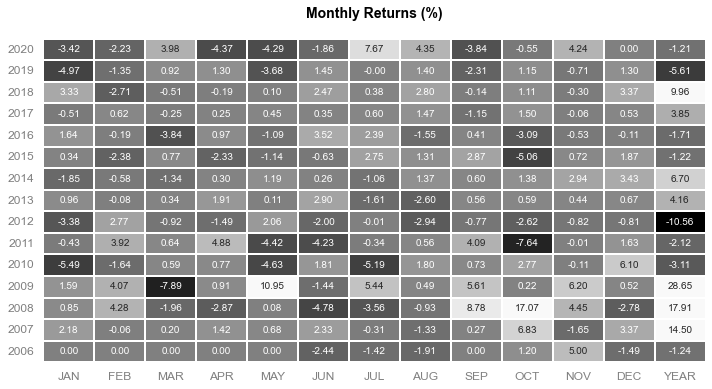

In [218]:

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(bench_return['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)
#yearly_returns = returns.div(100).add(1).cumprod(axis=1)['DEC'] - 1
#returns['YEAR'] = yearly_returns *100
#returns

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('../img/benchmark_table_montly_returns' + unique_name + '.png')
fig_table = fig 

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2020-11-25  2020-11-25
Risk-Free Rate             0.0%        0.0%
Time in Market             97.0%       97.0%

Cumulative Return          100.25%     67.19%
CAGR﹪                     4.77%       3.51%

Sharpe                     0.55        0.33
Prob. Sharpe Ratio         98.24%      89.83%
Smart Sharpe               0.53        0.32
Sortino                    0.79        0.47
Smart Sortino              0.76        0.45
Sortino/√2                 0.56        0.33
Smart Sortino/√2           0.54        0.32
Omega                      1.14        1.14

Max Drawdown               -15.25%     -21.02%
Longest DD Days            1102        2790
Volatility (ann.)          9.29%       12.99%
R^2                        0.89        0.89
Information Ratio          0.01        0.01
Calmar                     0.31        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-11-21,2009-01-06,2009-06-11,202,-15.251574,-13.989502
2,2008-03-18,2008-08-21,2008-10-06,202,-13.594401,-13.522146
3,2020-03-24,2020-06-05,2020-11-25,246,-12.750524,-12.445101
4,2008-10-28,2008-11-04,2008-11-19,22,-10.135953,-7.770383
5,2008-10-13,2008-10-13,2008-10-22,9,-8.390838,-7.917074


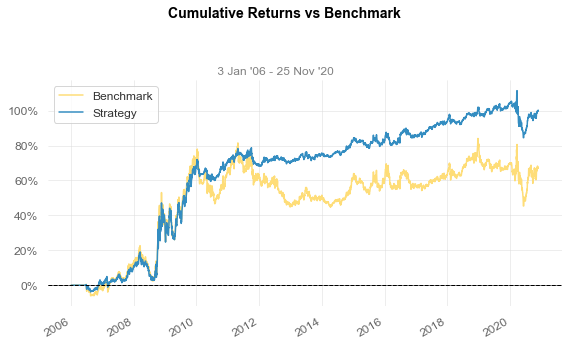

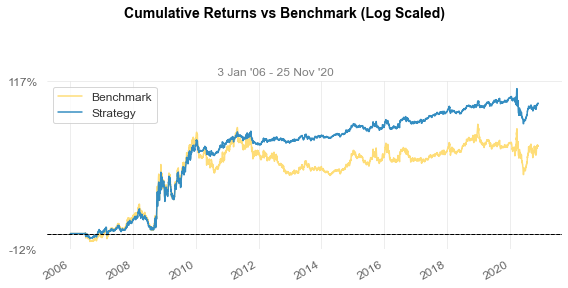

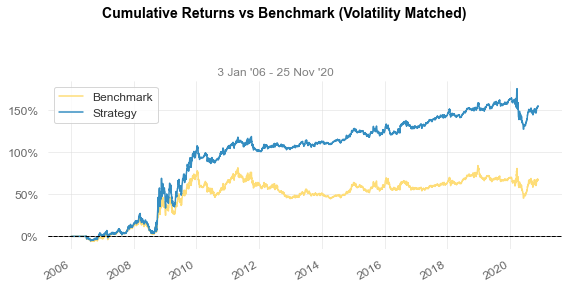

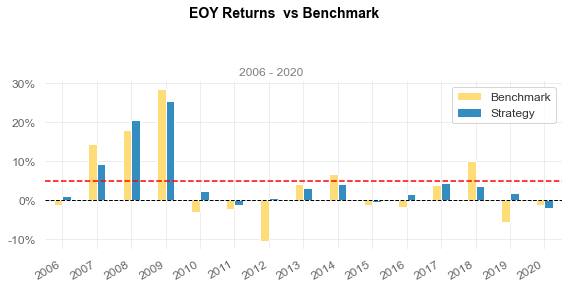

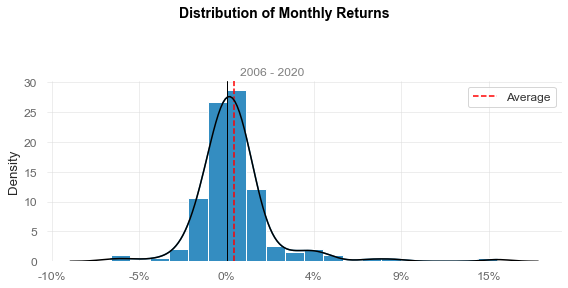

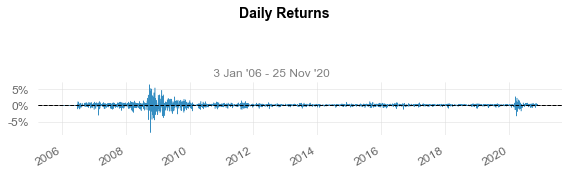

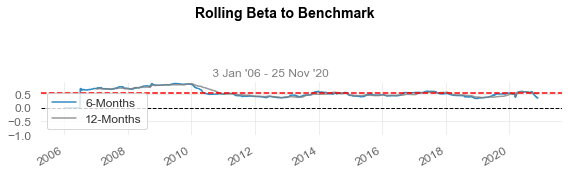

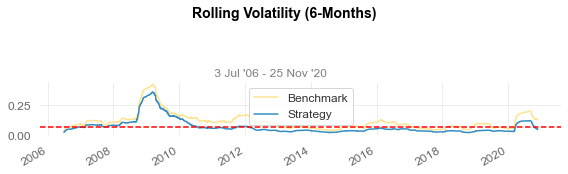

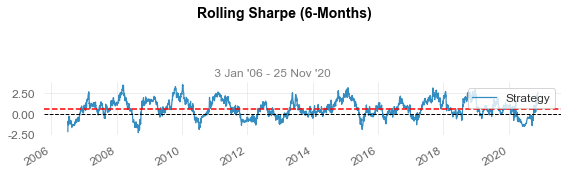

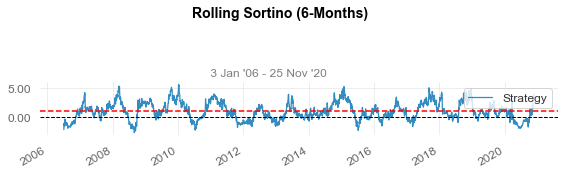

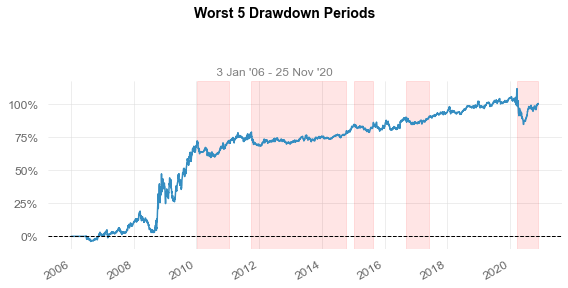

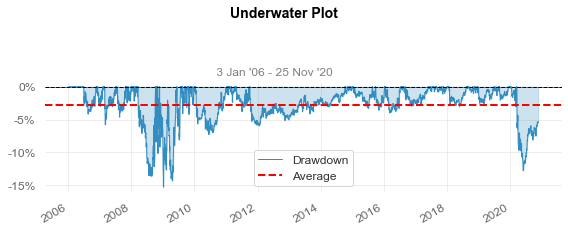

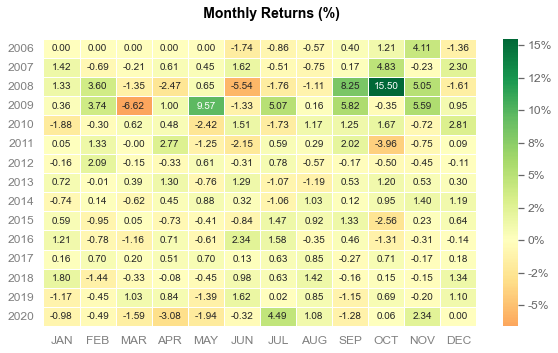

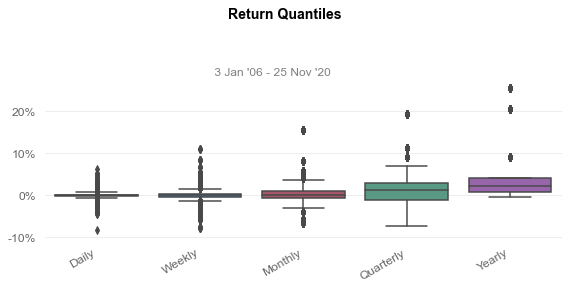

In [212]:
import quantstats as qs 

qs.reports.full(data_earnings['Tot'], benchmark = bench_return['Tot'])